In [1]:
from pivpy import io
from pivpy import graphics
import xarray as xr
import numpy as np

In [3]:
# read the arrays
data = io.load_vc7('../../tests/data/2Ca.VC7')

AttributeError: 'module' object has no attribute 'load_vc7'

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11bfef5f8>)

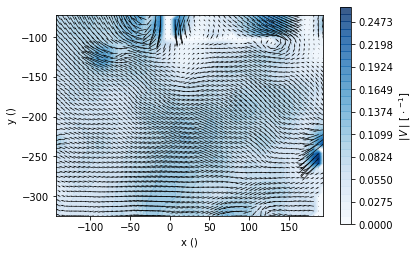

In [4]:
graphics.quiver(data,arrScale=10)

In [5]:
# we created a shortcut to the above cells in pivpy.io
data = io.load_vc7('../../tests/data/2Cb.VC7')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11d4a46d8>)

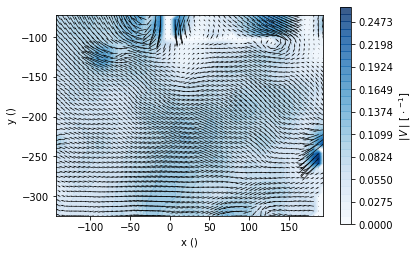

In [6]:
graphics.quiver(data,arrScale=10)